# **Báo cáo bài tập lớn môn Học máy**
**Giảng viên:** Trần Quốc Long<br>
**Lớp môn học:** INT3405E_20<br>
**Sinh viên:** Tần Lê Nghĩa<br>
**MSSV:** 18020949<br>

# **Mô tả bài toán**
**Quora** là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên **Quora**, mọi người có thể đặt câu hỏi và kết nối với những người khác, mọi người cùng nhau đóng góp thông tin chi tiết độc đáo và câu trả lời chất lượng. Tuy nhiên có một thực trạng đó là xuất hiện những câu hỏi thiếu chân thành - những câu hỏi được đặt ra mang thiên hướng tiên cực, quấy rối.

**Quora Insincere Question Classification** là một bài toán của **Quora** đặt ra, sử dụng sự trợ giúp từ cộng đồng, giúp họ phân loại những câu hỏi không chân thành.

Nhiệm vụ của bài toán là sử dụng tập dữ liệu mà **Quora** cung cấp để phân loại đâu là những câu hỏi mang hàm ý không chân thành, mang nội dung xấu độc, gây hiểu lầm.

In [1]:
import re
import sys
import math
import string
import zipfile
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from gensim.models import KeyedVectors
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import gc

tqdm_notebook.pandas()

# Phân tích dữ liệu

## Chuẩn bị dữ liệu

In [2]:
## Cấu trúc thư mục
!ls ../input/quora-insincere-questions-classification/

embeddings.zip	sample_submission.csv  test.csv  train.csv


Dữ liệu cuộc thi cung cấp gồm:
* `train.csv` dữ liệu huấn luyện
* `test.csv` dữ liệu kiểm thử
* `sample_submission.csv` file mẫu nộp lên cuộc thi
* `embeddings.zip` file chứa tập embeddings cuộc thi cung cấp do cuộc thi không cho sử dụng data bên ngoài

In [3]:
# Load dữ liệu
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

In [4]:
## Tổng quan dữ liệu train
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


Dữ liệu huấn luyện gồm **1306122** dòng dữ liệu.

Dữ liệu huấn luyện đầu vào gồm 3 cột thông tin:
* `qid`: ID của câu hỏi
* `question_text`: tiêu đề câu hỏi, dữ liệu ta cần phân loại
* `target`: kết quả cho thấy câu hỏi có thiếu chân thành không (1 - thiếu chân thành, 0 - chân thành)

Không có trường dữ liệu nào có **giá trị thiếu hoặc null**

In [6]:
# Tổng quan dữ liệu test
test_df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            375806 non-null  object
 1   question_text  375806 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


Dữ liệu kiểm thử gồm **375806** dòng dữ liệu.

Dữ liệu kiểm thử bao gồm 2 cột thông tin:
* `qid`: ID của câu hỏi
* `question_text`: tiêu đề câu hỏi, dữ liệu ta cần phân loại

Không có trường dữ liệu nào có **giá trị thiếu hoặc null**

## Trực quan hoá dữ liệu

Ta sẽ sử dụng **barplot** và **piechart** để có cái nhìn trực quan về phân bố dữ liệu.

<AxesSubplot:>

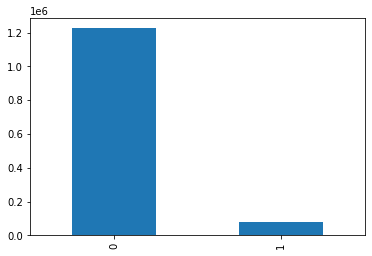

In [8]:
## Biểu đồ bar plot
train_df['target'].value_counts().plot(kind='bar')

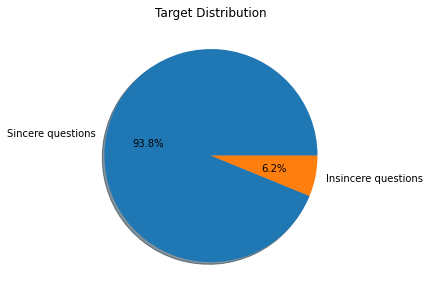

In [9]:
# Pie Chart
plt.subplot(1, 2, 2)
values = [train_df[train_df['target']==0].shape[0], train_df[train_df['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Target Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

**Vấn đề**: 

Số lượng câu hỏi thiếu chân thành (nhãn 1) **thấp hơn rất nhiều** so với các câu hỏi chân thành và chỉ chiếm **6.2%** trên toàn bộ dữ liệu

=> Dữ liệu bị mất cân bằng

Điều này có thể dẫn đến một số vấn đề:

Mô hình dự đoán kém: Mô hình sẽ có thiên hướng dự đoán thiên lệch về nhãn đa số.

Đánh giá sai chất lượng mô hình: Ta sẽ không thể đánh giá mô hình bằng độ đo **accuracy** hay **recall** bởi mô hình có thể dự đoán toàn bộ mẫu là 0 mặc dù trong khi đó accuracy và recall lại đạt giá trị cao.

Vì vậy ta sẽ lựa chọn hàm đánh giá là **F1_score** để đánh giá chất lượng mô hình

## WordCloud

**WordCloud** sẽ giúp chúng ta có cái nhìn trực quan về các từ sẽ chủ yếu xuất hiện trong các câu không chân thành và chân thành

Các từ xuất hiện tần suất càng nhiều thì từ đó sẽ được hiển thị to và đậm

Ta sẽ định nghĩa hàm: 
* `word_freq_dict` tạo từ điển về tần suất xuất hiện các từ
* `word_cloud_frequency` hàm hiển thị WordCloud từ điển tần suất. Trong hàm này sẽ được loại bỏ các stopword dựa vào thư viện nltk để lấy ra những từ đặc trưng nhất cho hai nhãn

In [10]:
# Stopword từ nltk
stop_words = set(stopwords.words('english'))

# Tạo từ điển tần suất
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    vocab = Counter(wordList) 
    freq_dict = dict(vocab.most_common())
    return freq_dict
    
# Plot a wordcloud from a word frequency dictionary
def word_cloud_frequency(word_freq_dict, title, figure_size=(10,6)):
    for w in stop_words:
        if w in word_freq_dict:
            word_freq_dict.pop(w)
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

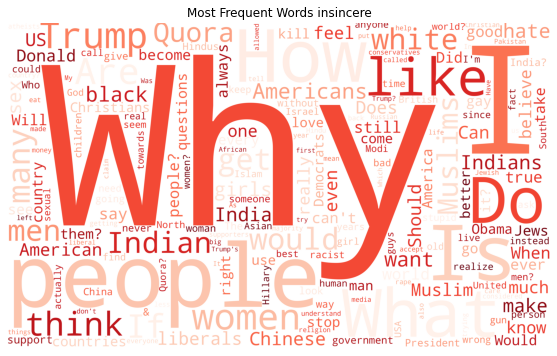

In [11]:
# Wordcloud of insincere questions
insincere_questions = train_df.question_text[train_df['target'] == 1]
insincere_sample = " ".join(insincere_questions)
insincere_word_freq = word_freq_dict(insincere_sample)
insincere_word_freq = dict(list(insincere_word_freq.items()))
wordcloud = WordCloud(width= 5000,
    height=3000,
    max_words=200,
    colormap='Reds',
    background_color='white')

word_cloud_frequency(insincere_word_freq, "Most Frequent Words insincere")

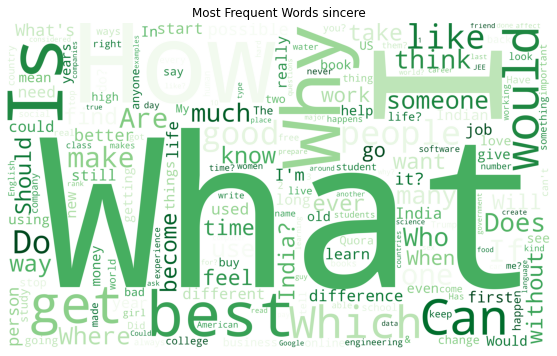

In [12]:
# Wordcloud of insincere questions
insincere_questions = train_df.question_text[train_df['target'] == 0]
insincere_sample = " ".join(insincere_questions)
insincere_word_freq = word_freq_dict(insincere_sample)
insincere_word_freq = dict(list(insincere_word_freq.items()))
wordcloud = WordCloud(width= 5000,
    height=3000,
    max_words=200,
    colormap='Greens',
    background_color='white')

word_cloud_frequency(insincere_word_freq, "Most Frequent Words sincere")

**Kết luận:**

Ta thấy đôi với các câu hỏi không chân thành các từ xuất hiện có thiên hướng tiêu cực, phân biệt và phản cảm ví dụ như: **muslims, sex, black, white ...**

Đối với các câu hỏi chân thành các từ xuất hiện mang ý nghĩa tích cực, mang hàm ý là một câu hỏi hơn: **best, when, what, like ...**

# Tiền xử lí dữ liệu

## Load embedding vector

Dữ liệu ban đầu là dữ liệu thô chưa qua xử lí là dữ liệu mà mô hình không thể hiểu được vì vậy ta cần nhúng nó vào chiều không gian vector.

Ở đây ta sẽ sử dụng bộ **embeddings** của **GoogleNews** được cuộc thi cung cấp là bộ embedding được Google huấn luyện bằng hai phương pháp **Word2Vec** là Cbow và Skipgram.

![](https://www.samyzaf.com/ML/nlp/word2vec2.png)

Các từ khi được nhúng vào chiều không gian vẫn sẽ giữ được quan hệ ngữ nghĩa giữa các từ với nhau

In [13]:
# Giải nén và load embeddings
zip_file = zipfile.ZipFile('/kaggle/input/quora-insincere-questions-classification/embeddings.zip', 'r')
path=zip_file.open('GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', 'r')

embeddings_index = KeyedVectors.load_word2vec_format(path, binary=True)

Sau khi load được bộ **embeddings**, chúng ta sẽ kiểm tra độ bao phủ của tập này trên dữ liệu.

Sử dụng hàm `check_coverage` và từ điển tần suất như ở phần WordCloud

In [14]:
# Hàm kiểm tra độ bao phủ embedding
def check_coverage(vocab, embeddings_index):
    embeddings_vocab = 0
    embeddings_text = 0
    oov_text = 0
    oov = Counter()
    
    for word in vocab:
        if word in embeddings_index:
            embeddings_vocab += 1
            embeddings_text += vocab[word]    
        else:
            oov[word] = vocab[word]
            oov_text += vocab[word]

    print('Embeddings coverage for {:.2%} of vocab'.format(embeddings_vocab / len(vocab)))
    print('Embeddings coverage for {:.2%} of all text'.format(embeddings_text / (embeddings_text + oov_text)))
    
    return oov

In [15]:
## Kiểm tra độ bao phủ
data = " ".join(train_df.question_text)
vocab = word_freq_dict(data)
oov = check_coverage(vocab, embeddings_index)

Embeddings coverage for 24.31% of vocab
Embeddings coverage for 78.75% of all text


In [16]:
## Hiển thị 20 từ OOV
print('Out of vocab')
oov.most_common(20)

Out of vocab


[('to', 403183),
 ('a', 402682),
 ('of', 330825),
 ('and', 251973),
 ('India?', 16384),
 ('it?', 12900),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386),
 ('people?', 4971),
 ('why?', 4943),
 ('Quora?', 4655),
 ('10', 4591),
 ('like?', 4487),
 ('for?', 4450),
 ('work?', 4206)]

**Vấn đề:**

Độ bao phủ của tập embeddings đang rất thấp chỉ chiếm **24.31%** và **78.75%**

Qua OOV ta có thể thấy các kí tự đặc biệt cụ thể là dấu hỏi đang lẫn vào các từ, các kí tự này không có quá nhiều ý nghĩa. 

=> Vì vậy ta sẽ loại bỏ chúng


## Loại bỏ kí tự đặc biệt và chuẩn hoá từ viết tắt

Ta sẽ xây dựng một list các kí tự đặc biệt và dấu tách câu từ string của python và sys.

Đối với các kí tự nằm trong embedding ta sẽ cho nó nằm riêng rẽ ra, còn đối với kí tự không nằm trong embedding ta sẽ thay thế bằng dấu cách.

Sử dụng hàm `remove_punct`

In [17]:
# Xây dựng tập punctuations
punctuation = [chr(i) for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P')]
for punct in string.punctuation:
    if punct not in punctuation:
        punctuation.append(punct)
punctuation_in_embeddings = [punct for punct in punctuation if punct in embeddings_index]
punctuation_not_in_embeddings = [punct for punct in punctuation if punct not in embeddings_index]

# Loại bỏ punctuations khỏi text
def remove_punct(sen):
    for punct in punctuation_not_in_embeddings:
        sen = sen.replace(punct, ' ')
    for punct in punctuation_in_embeddings:
        sen = sen.replace(punct, f' {punct} ')
    return sen

In [18]:
# Check độ bao phủ
sentens = train_df['question_text'].progress_apply(lambda x: remove_punct(x))
data = " ".join(sentens)
vocab = word_freq_dict(data)
oov = check_coverage(vocab, embeddings_index)
print('Out of vocab')
oov.most_common(20)

  0%|          | 0/1306122 [00:00<?, ?it/s]

Embeddings coverage for 60.58% of vocab
Embeddings coverage for 90.14% of all text
Out of vocab


[('to', 406419),
 ('a', 404740),
 ('of', 333011),
 ('and', 254186),
 ('2017', 8863),
 ('10', 7471),
 ('2018', 7415),
 ('12', 3863),
 ('100', 3122),
 ('20', 3048),
 ('15', 2682),
 ('12th', 2568),
 ('11', 2536),
 ('30', 2284),
 ('50', 2223),
 ('18', 2153),
 ('000', 2106),
 ('16', 1683),
 ('14', 1636),
 ('17', 1599)]

Check lại độ bao phủ ta thấy:

Độ bao phủ đã tăng lên đáng kể từ **24%** lên **60.58%**

**Vấn đề:**

Chúng ta thấy oov đang xuất hiện nhiều **kí tự số**

## Chuẩn hoá kí tự số

In [19]:
## Kiểm tra top 10 từ xuất hiện nhiều nhất
for i in range(10):
    print(embeddings_index.index_to_key[i])

</s>
in
for
that
is
on
##
The
with
said


In [20]:
## Kiểm tra kí tự số trong tập embedding
print('1' in embeddings_index)
print('22' in embeddings_index)

True
False


Khảo sát về kí tự số ta thấy rằng embeddings của GoogleNews sẽ thay thế các số có hai chữ số trở lên bằng kí **#** </br>
Với **22** sẽ là **##**, **333** sẽ là **###** và tương tự 

Vì vậy ta sẽ định nghĩa hàm chuẩn hoá `standard_numbers` để chuẩn hoá lại các kí tự số


In [21]:
# Hàm chuẩn hoá kí tự số
def standard_numbers(x):
    ## Sử dụng regex
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [22]:
# Check độ bao phủ

sentens = sentens.progress_apply(lambda x: standard_numbers(x))
data = " ".join(sentens)
vocab = word_freq_dict(data)
oov = check_coverage(vocab, embeddings_index)
print('Out of vocab')
oov.most_common(20)

  0%|          | 0/1306122 [00:00<?, ?it/s]

Embeddings coverage for 63.30% of vocab
Embeddings coverage for 90.90% of all text
Out of vocab


[('to', 406419),
 ('a', 404740),
 ('of', 333011),
 ('and', 254186),
 ('favourite', 1247),
 ('bitcoin', 991),
 ('colour', 978),
 ('centre', 889),
 ('Quorans', 856),
 ('cryptocurrency', 821),
 ('Snapchat', 809),
 ('travelling', 705),
 ('counselling', 634),
 ('Brexit', 493),
 ('btech', 485),
 ('cryptocurrencies', 481),
 ('blockchain', 481),
 ('behaviour', 470),
 ('upvotes', 432),
 ('programme', 403)]

Check lại độ bao phủ ta thấy:

Độ bao phủ đã tăng lên **63.30%**

**Vấn đề:**

Chúng ta thấy oov đang xuất hiện nhiều lỗi ngữ pháp và các từ mới.

## Xử lí ngữ pháp và các từ mới

Ta sẽ chuẩn hoá lại về ngữ pháp cùng một số từ mới:
* Ngữ pháp Anh-Anh về Anh-Mỹ như **labour** thành **labor**
* Từ mới **Ethereum** thành **crypto**
* Các từ viết tắt **INTJ** thành **Introversion Intuition Thinking Judgment**

Định nghĩa hàm `correct_spelling` để xử lí việc này

Bên cạnh đó ta sẽ định nghĩa hàm `replace_useless` để loại bỏ các kí tự **a, of** đang xuất hiện nhiều nhưng không quá nhiều ý nghĩa

In [23]:
# Từ điển mispell
mispell_dict = {
    'grey': 'gray',
    'litre': 'liter',
    'labour': 'labor',
    'travelling':'traveling',
    'favour': 'favor',
    'colour': 'color',
    'centre': 'center',
    'honours': 'honor',
    'theatre': 'theater',
    'realise': 'realize',
    'defence': 'defense',
    'licence': 'license',
    'analyse': 'analyze',
    'practise': 'practice',
    'behaviour': 'behavior',
    'neighbour': 'neighbor',
    'recognise': 'recognize',
    'organisation':'organization',  
    'Qoura': 'Quora',
    'quora': 'Quora',
    'Quorans': 'Quoran',
    'infty': 'infinity',
    'judgement': 'judge',   
    'isnt': 'is not',
    'didnt': 'did not',
    'Whatis': 'what is',
    'doesnt': 'does not',  
    'learnt': 'learn',
    'modelling': 'model',
    'cancelled': 'cancel',
    'travelled': 'travell',
    'travelling': 'travel',
    'aluminium': 'alumini',
    'counselling':'counseling',
    '₹': 'rupee',
    'Brexit': 'Britain exit',
    'Paytm': 'Pay Through Mobile',
    'KVPY': 'Kishore Vaigyanik Protsahan Yojana',
    'GDPR': 'General Data Protection Regulation',
    'INTJ': 'Introversion Intuition Thinking Judgment',   
    'cheque': 'bill',
    'upvote': 'agree',
    'upvotes': 'agree',
    'vape': 'cigarette',
    'jewellery': 'jewell',
    'Fiverr': 'freelance',
    'programd': 'program',
    'programme': 'program',
    'programr': 'programer',
    'programrs': 'programer',
    'WeChat': 'socialmedia',
    'Snapchat': 'socialmedia',
    'Redmi': 'cellphone',
    'Xiaomi': 'cellphone',
    'OnePlus': 'cellphone',
    'cryptos': 'crypto',
    'bitcoin': 'crypto',
    'Coinbase': 'crypto',
    'bitcoins': 'crypto',
    'ethereum': 'crypto',
    'Ethereum': 'crypto',
    'Blockchain': 'crypto',
    'blockchain': 'crypto',
    'cryptocurrency': 'crypto',
    'cryptocurrencies': 'crypto',
}
## Chuẩn hoá ngữ pháp và từ mới
def correct_spelling(sen):
    for word in mispell_dict.keys():
        sen = sen.replace(word, mispell_dict[word])
    return sen

In [24]:
## Xoá bỏ a, to, of
def replace_useless(sen):
    text_list = sen.split()
    text_list = [text for text in text_list if text not in ['a', 'to', 'of', 'and']]
    return " ".join(text_list)

In [25]:
# Check độ bao phủ

sentens = sentens.progress_apply(lambda x: correct_spelling(x))
sentens = sentens.progress_apply(lambda x: replace_useless(x))

data = " ".join(sentens)
vocab = word_freq_dict(data)
oov = check_coverage(vocab, embeddings_index)
print('Out of vocab')
oov.most_common(20)

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

Embeddings coverage for 63.33% of vocab
Embeddings coverage for 99.15% of all text
Out of vocab


[('btech', 485),
 ('Vaigyanik', 349),
 ('cryptos', 277),
 ('mtech', 219),
 ('Pinterest', 162),
 ('INFJ', 159),
 ('aadhar', 151),
 ('Btech', 150),
 ('Coursera', 138),
 ('Fortnite', 130),
 ('Lyft', 125),
 ('UCEED', 123),
 ('AFCAT', 122),
 ('bcom', 119),
 ('INFP', 113),
 ('displaystyle', 111),
 ('demonetisation', 106),
 ('UPSEE', 105),
 ('##°', 102),
 ('Machedo', 99)]

Độ bao phủ đã tăng lên **63.33%** và **99,15%** so với toàn bộ dữ liệu

=> Ta sẽ sử dụng các phương pháp này để làm sạch dữ liệu

## Tổng hợp hàm tiền xử lí dữ liệu

Ta sẽ tổng hợp lại các phương pháp trên trong hàm `data_cleaning` để xử lí dữ liệu 

In [26]:
## Tổng hợp lại clean data
def data_cleaning(sen):
  sen = remove_punct(sen)
  sen = standard_numbers(sen)
  sen = correct_spelling(sen)
  sen = replace_useless(sen)

  return sen

In [27]:
## Clean dữ liệu
train_df['question_text_cleaned'] = train_df['question_text'].progress_apply(lambda x: data_cleaning(x))
test_df['question_text_cleaned'] = test_df['question_text'].progress_apply(lambda x: data_cleaning(x))

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/375806 [00:00<?, ?it/s]

In [28]:
## Xoá các biến không dùng đến
del oov, sentens
gc.collect()

5665

# Data Generator

Ta chia tập dữ liệu thành hai tập dữ liệu **train** và **validation**

Với tập train tác dụng tìm tham số cho mô hình

Với tập validation giúp tìm siêu tham số, độ phức tạp cho mô hình tránh mô hình bị **overfitting**

Thêm vào đó dữ liệu này là dữ liệu bị lệch nên ta sẽ chia mẫu phân tầng **stratify** đảm bảo tỉ lệ giữa hai nhãn trong hai tập là như nhau

In [29]:
## Chia tập dữ liệu
train_df, val_df = train_test_split(train_df, test_size = 0.1, stratify = train_df['target'], random_state = 42)

In [30]:
## Hiển thị phân bố nhãn trong hai tập
print(train_df.shape)
print(train_df['target'].value_counts())
print(val_df.shape)
print(val_df['target'].value_counts())

(1175509, 4)
0    1102780
1      72729
Name: target, dtype: int64
(130613, 4)
0    122532
1      8081
Name: target, dtype: int64


**Vấn đề:** 
Do bộ dữ liệu quá lớn ta sẽ tạo hàm generator để sinh dữ liệu theo batch. Điều này giúp cho quá trình train không bị tốn bộ nhớ.

Ở mỗi batch sẽ trả về cho model 2 thông tin đó là tập embedding câu và tập nhãn tương ứng

Ta sử dụng hàm `text_to_array` để sinh ra bộ ma trận em bedding của một batch các câu với SEQ_LEN = 30, EMBED_DIM = 300 chính là chiều vector của **GoogleNews**

Hàm `batch_train_gen` để sinh các batch với batch-size là 128 là hàm mũ của hai giúp tận dụng khả năng tính toán song song

In [31]:
SEQ_LEN = 30
batch_size = 128
EMB_SIZE = 300

# Hàm chuyển text thành vector embedding
def text_to_array(sen):
    empyt_emb = np.zeros(EMB_SIZE)
    sen = sen[:-1].split()[:SEQ_LEN]
    embeds = [embeddings_index[x] for x in sen if x in embeddings_index]
    embeds+= [empyt_emb] * (SEQ_LEN - len(embeds))
    return np.array(embeds)

# Hàm sinh dữ liệu
def batch_train_gen(train_df):
    n_batches = math.ceil(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.) 
        for i in range(n_batches):
            texts = train_df.iloc[i * batch_size: (i + 1) * batch_size, -1]
            text_arr = np.array([text_to_array(text) for text in texts])
            yield text_arr, np.array(train_df["target"][i * batch_size:(i + 1) * batch_size])

In [32]:
# train_gen = batch_train_gen(train_df)
# val_gen = batch_val_gen(val_df)

In [33]:
## Khai báo hàm sinh dữ liệu
train_gen = batch_train_gen(train_df)
val_size = 10000
val_vects = np.array([text_to_array(X_text) for X_text in tqdm(val_df["question_text_cleaned"][:val_size],position=0)], dtype=float)
val_y = np.array(val_df["target"][:val_size], dtype='int32')
validation_data=(val_vects, val_y)

100%|██████████| 10000/10000 [00:00<00:00, 10288.68it/s]


In [34]:
## Kiểm tra định dạng
next(iter(train_gen))[0].shape

(128, 30, 300)

# Mô hình 

In [35]:
from keras.models import Sequential,Model
from keras.layers import CuDNNLSTM, Dense, Bidirectional, Input,Dropout, LSTM
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [36]:
# Hàm hiển thị history
def plot_his(history):
    # plot history for loss
    plt.figure(figsize=(15, 5)).add_subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot history for accuracy
    plt.figure(figsize=(15, 5)).add_subplot(1, 3, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Ở đây ta sẽ thử nghiệm hai mô hình đó **LSTM** và **BiLSTM**

LSTM là biến thể của RNN là mô hình xử lí dữ liệu dạng chuỗi. 

Tuy nhiên RNN có hai nhược điểm đó là **vanishing gradient** và hạn chế trong việc **lưu trữ thông tin** giữa các từ xa nhau trong câu.

LSTM ra đời để hạn chế những hạn chế này của RNN.

![](https://i.stack.imgur.com/aTDpS.png)

Bao gồm hidden state **h(t)** chứa thông tin short-term và cell state **c(t)** chứa thông tin long-term

Với mỗi h(t) sẽ gồm ba cổng làm nhiệm vụ quản lí thông tin:
* Forget gate f(t): kiểm soát thông tin nên quên và giữ từ cell state trước đó
* Input gate i(t): kiểm soát chọn lọc những thông tin mới để ghi vào cell state hiện tại
* Output gate o(t): Xác định thông tin nào từ cell state hiện tại để truyền tới các hidden state tiếp theo

## LSTM

In [37]:
# Sử dụng sequential để xây dựng
lstm_model = Sequential()

# Thêm Lstm với unit là 128
lstm_model.add(LSTM(units=128))

# Thêm fullyconnected layer cùng với sigmoid để dự đoán 
lstm_model.add(Dense(1, activation="sigmoid"))

# Compile neural network
lstm_model.compile(loss='binary_crossentropy', # Cross-entropy
              optimizer='adam', # Adam optimization
              metrics=['accuracy']) # Accuracy performance metric


2022-01-07 17:22:59.813438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 17:22:59.964441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 17:22:59.965195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 17:22:59.966378: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Đối với hai mô hình ta sẽ setup các hàm callbacks hỗ trợ cho mô hình tối ưu tốt hơn:
* `checkpoint`: lưu mô hình nếu validation_loss giảm sau mỗi epoch
* `reduceLROnPlat`: ta sẽ giảm learning rate với công thức `newlr = oldlr * 0.2` nếu sau 2 epoch val_loss không giảm
* `EarlyStopping`: Dừng học mô hình nếu sau 3 epoch val_loss không giảm

In [38]:
filepath = 'Lstm-{epoch:02d}-{val_loss:.4f}.hdf5'
## Giảm lr
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.20, min_delta=1e-15 ,patience=2, 
                                   verbose=1, mode='min')
## Lưu mô hình 
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
## Early stop
earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=True)
callbacks = [reduceLROnPlat, earlystopper]

In [39]:
lstm_history = lstm_model.fit(train_gen,
                    epochs=30,
                    steps_per_epoch=1000, 
                    validation_data=validation_data,
                    callbacks=callbacks,
                    verbose=True)

2022-01-07 17:23:04.383126: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-01-07 17:23:05.709753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
 997/1000 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9472

2022-01-07 17:23:22.785513: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 360000000 exceeds 10% of free system memory.
2022-01-07 17:23:23.175184: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 360000000 exceeds 10% of free system memory.


1000/1000 [==============================] - 19s 17ms/step - loss: 0.1485 - accuracy: 0.9472 - val_loss: 0.1431 - val_accuracy: 0.9469
Epoch 2/30
1000/1000 [==============================] - 16s 16ms/step - loss: 0.1283 - accuracy: 0.9505 - val_loss: 0.1323 - val_accuracy: 0.9482
Epoch 3/30
1000/1000 [==============================] - 15s 16ms/step - loss: 0.1217 - accuracy: 0.9524 - val_loss: 0.1202 - val_accuracy: 0.9528
Epoch 4/30
1000/1000 [==============================] - 16s 16ms/step - loss: 0.1234 - accuracy: 0.9524 - val_loss: 0.1198 - val_accuracy: 0.9532
Epoch 5/30
1000/1000 [==============================] - 15s 15ms/step - loss: 0.1197 - accuracy: 0.9530 - val_loss: 0.1155 - val_accuracy: 0.9541
Epoch 6/30
1000/1000 [==============================] - 16s 16ms/step - loss: 0.1150 - accuracy: 0.9550 - val_loss: 0.1178 - val_accuracy: 0.9552
Epoch 7/30
1000/1000 [==============================] - 16s 16ms/step - loss: 0.1155 - accuracy: 0.9554 - val_loss: 0.1146 - val_accura

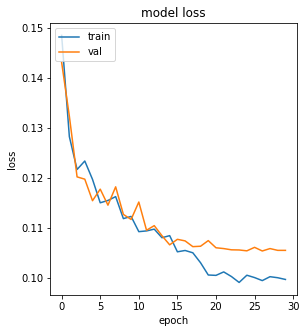

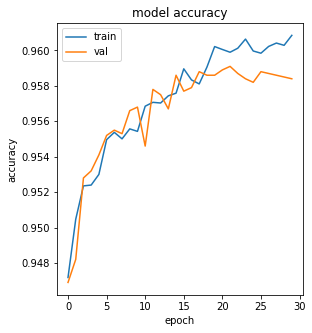

In [40]:
## Hiển thị history
plot_his(lstm_history)

## Mô hình BiLSTM

![](https://miro.medium.com/max/1098/1*xdvd-PJewtzFF6vP55ObwA.png)
Mô hình **bi-lstm** với phần xương sống vẫn là **lstm**

Tuy nhiên nó học ngữ cảnh theo hai chiều (bi-directional).

Vì vậy nó sẽ học ngữ cảnh của từ so với các từ trong quá khứ và tương lai.

Ta sẽ xây dựng mô hình **Bi-LSTM** với 2 layer chồng lên nhau.

In [41]:
## Xây dựng sequential
model = Sequential()
## Layer1
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True),
                        input_shape=(30, 300)))
## Layer 2
model.add(Bidirectional(CuDNNLSTM(64)))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 128)           187392    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               99328     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 286,849
Trainable params: 286,849
Non-trainable params: 0
_________________________________________________________________


Set up callback tương tự LSTM

In [43]:
filepath = 'BiLstm-{epoch:02d}-{val_loss:.4f}.hdf5'
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.20, min_delta=1e-15 ,patience=2, 
                                   verbose=1, mode='min')
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=True)
callbacks = [reduceLROnPlat, earlystopper]

In [44]:
# train_step = math.ceil(len(train_df) / batch_size)
# val_step = math.ceil(len(val_df) / batch_size)

# history = model.fit(train_gen, batch_size=batch_size, epochs= 10, steps_per_epoch=train_step, validation_data = val_gen, validation_steps=val_step, verbose=True, callbacks=callbacks)

In [45]:
history = model.fit(train_gen,
                    epochs=30,
                    steps_per_epoch=1000, 
                    validation_data=validation_data,
                    callbacks=callbacks,
                    verbose=True)

Epoch 1/30
 997/1000 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9473

2022-01-07 17:32:26.586381: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 360000000 exceeds 10% of free system memory.
2022-01-07 17:32:26.970763: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 360000000 exceeds 10% of free system memory.


1000/1000 [==============================] - 23s 21ms/step - loss: 0.1422 - accuracy: 0.9473 - val_loss: 0.1260 - val_accuracy: 0.9535
Epoch 2/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.1256 - accuracy: 0.9507 - val_loss: 0.1223 - val_accuracy: 0.9522
Epoch 3/30
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1200 - accuracy: 0.9533 - val_loss: 0.1195 - val_accuracy: 0.9529
Epoch 4/30
1000/1000 [==============================] - 21s 21ms/step - loss: 0.1191 - accuracy: 0.9534 - val_loss: 0.1200 - val_accuracy: 0.9550
Epoch 5/30
1000/1000 [==============================] - 21s 21ms/step - loss: 0.1154 - accuracy: 0.9550 - val_loss: 0.1154 - val_accuracy: 0.9551
Epoch 6/30
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1130 - accuracy: 0.9556 - val_loss: 0.1195 - val_accuracy: 0.9547
Epoch 7/30
1000/1000 [==============================] - 22s 22ms/step - loss: 0.1108 - accuracy: 0.9562 - val_loss: 0.1133 - val_accura

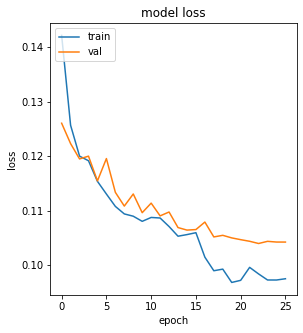

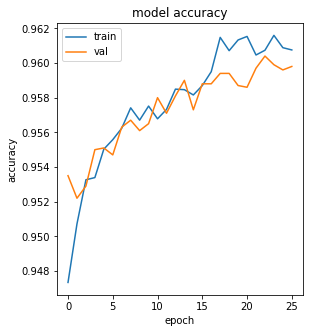

In [46]:
plot_his(history)

# Dự đoán dữ liệu test và submission

Ta sẽ lựa chọn threshold tốt nhất cho hai mô hình sao cho giá trị **f1_score** là cao nhất sau đó chọn mô hình tốt nhất sử dụng hàm **best_threshold**.

Ta sẽ đặt khoảng thres từ 0.1 đến 0.7 bởi chúng ta muốn tỉ lệ false positive cao hơn một chút do dữ liệu mất cân bằng về phía nhãn 0.

In [47]:
pred_val = lstm_model.predict(val_vects, verbose=False)

## Hàm threshold
def best_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.701, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

y_val_truth = np.array(val_df['target'])
score_val, threshold_val = best_threshold(pred_val, val_y)


print("The best threshold is {0} with f1_score {1} of LSTM".format(score_val, threshold_val))

2022-01-07 17:41:58.222402: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 360000000 exceeds 10% of free system memory.


The best threshold is 0.666157372039725 with f1_score 0.35 of LSTM


In [48]:
pred_val_bi_lstm = model.predict(val_vects, verbose=False)
score_val_bi, threshold_val_bi = best_threshold(pred_val_bi_lstm, val_y)
print("The best threshold is {0} with f1_score {1} of Bi-LSTM model".format(score_val_bi, threshold_val_bi))

The best threshold is 0.6706766917293233 with f1_score 0.32 of Bi-LSTM model


In [49]:
def batch_test_gen(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i * batch_size: (i + 1) * batch_size, 1]
        text_arr = [text_to_array(text) for text in texts]
        yield np.array(text_arr, dtype=float)

Ta sẽ lựa chọn mô hình có điểm **f1_score** cao hơn để dự đoán tập test

In [50]:
all_preds = []
final_thres = 0
res = 0
for x in tqdm(batch_test_gen(test_df)):
    if score_val_bi > score_val:
        res = model.predict(x, verbose=False)
        final_thres = threshold_val_bi
    else:
        res = lstm_model.predict(x, verbose=False)
        final_thres = threshold_val
    res = (res > final_thres ).astype(int)
    for i in res:
        all_preds.append(i[0])

2936it [03:15, 15.03it/s]


In [51]:
print(final_thres)

0.32


In [52]:
submit_df = pd.DataFrame({"qid": test_df["qid"], "prediction": all_preds})
submit_df.head(5)

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [53]:
submit_df.to_csv("submission.csv", index=False)

# Kết quả đạt được

![](./Res.png)


Kết quả đạt được cho **public score** là 0.63912 và đối với **Private Score** là 0.65743